# Semi-supervised Node Classification on Molecular Structures
## Node prediction

## Preliminary imports and definition of utilities

In [1]:
import json
import os

import dgl
import dgl.nn as gnn
import hydra
import ipywidgets as widgets
import matplotlib
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import py3Dmol
import pymatgen.core as mg
import seaborn as sns
import torch
import torch.nn.functional as F
from IPython import display
from ipywidgets import Button, Dropdown, HBox, VBox
from  matplotlib import gridspec
from matplotlib.colors import LinearSegmentedColormap
from sklearn.metrics import (ConfusionMatrixDisplay, accuracy_score,
                             confusion_matrix, f1_score)
from torch import nn
from torchviz import make_dot
from tqdm.notebook import tqdm

from src.lib.lib_trainer import PLEGATNodePredictorAndRegressor
from matgl.layers._basis import GaussianExpansion

hydra.initialize(config_path="src/config")
cfg = hydra.compose(config_name='train', overrides=[], return_hydra_config=True)

os.environ.setdefault('DGLBACKEND','pytorch')

device = 'cpu'
if torch.cuda.is_available():
    device='cuda'

# Load cmap for graph coloring
df_colors = pd.read_csv("https://raw.githubusercontent.com/CorySimon/JMolColors/master/jmolcolors.csv")
colors = ['#000000']
for i in range(1,95):
    atom = mg.Element.from_Z(i).name
    r = df_colors[df_colors['atom'] == atom]['R'].values[0]
    g = df_colors[df_colors['atom'] == atom]['G'].values[0]
    b = df_colors[df_colors['atom'] == atom]['B'].values[0]
    colors.append('#{:02x}{:02x}{:02x}'.format(r, g, b))
cmap = LinearSegmentedColormap.from_list('Atoms',colors)

# Set to true to dynamically explore attention maps
INTERACTIVE = False

C:\Users\tomma\AppData\Local\Temp\ipykernel_2212\42445180.py:31: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  hydra.initialize(config_path="src/config")


### Show the EGAT that is being used

In [2]:
model = PLEGATNodePredictorAndRegressor(cfg)
print(model)
tot = 0
for name, param in model.named_parameters():
    print(name, param.shape,param.numel())
    tot += param.numel()
print('Total number of params:', tot)

PLEGATNodePredictorAndRegressor(
  (net): AllInOneEGAT(
    (gat): MyEGAT(
      (embedding): Embedding(95, 16)
      (convs): Sequential(
        (0): EGATConv(
          (fc_node_src): Linear(in_features=16, out_features=128, bias=False)
          (fc_ni): Linear(in_features=16, out_features=512, bias=False)
          (fc_nj): Linear(in_features=16, out_features=512, bias=False)
          (fc_fij): Linear(in_features=100, out_features=512, bias=False)
        )
        (1): EGATConv(
          (fc_node_src): Linear(in_features=128, out_features=256, bias=False)
          (fc_ni): Linear(in_features=128, out_features=512, bias=False)
          (fc_nj): Linear(in_features=128, out_features=512, bias=False)
          (fc_fij): Linear(in_features=512, out_features=512, bias=False)
        )
      )
    )
    (node_s2s): Set2Set(
      n_iters=2
      (lstm): LSTM(512, 256)
    )
    (edge_s2s): EdgeSet2Set(
      (lstm): LSTM(1024, 512, num_layers=2)
    )
    (regressor): GatedMLP(
    

In [3]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self,graphs):
        super(MyDataset).__init__()
        self.graphs = graphs
        
    def __getitem__(self,idx):
        return self.graphs[idx]
    
    def __len__(self):
        return len(self.graphs)
    
def mask_labels(labels, sample_frac=0.2):
    mask = torch.rand(len(labels),device=labels.device) < sample_frac
    return labels * ~mask, mask

def compute_attentions(model,g,nfeats,efeats):
    attentions = []
    nfeats = model.gat.embedding(nfeats)
    for layer in model.gat.convs: 
        nfeats,efeats,attn = layer(g,nfeats,efeats,get_attention=True)#.view(g.num_nodes(),-1)    
        nfeats = model.gat.activation(nfeats.view(g.num_nodes(),-1))
        efeats = model.gat.activation(efeats.view(g.num_edges(),-1))    
        attentions.append(attn)

    # Graph level prediction
    node_vec = model.node_s2s(g, nfeats)
    edge_vec = model.edge_s2s(g, efeats)
    node_vec = torch.squeeze(node_vec)
    edge_vec = torch.squeeze(edge_vec)
    vec = torch.hstack([node_vec, edge_vec])
    g_out = model.regressor(vec)
    if model.is_graph_classification:
        g_out = F.softmax(g_out,dim=1)

    # Node and Edge level predictions
    n_out,e_out,attn = model.classifier(g,nfeats,efeats)
    n_out = n_out.mean(dim=1)
    e_out = e_out.mean(dim=1)
    attentions.append(attn)

    return {'graph':g_out,
            'node':n_out,
            'edge':e_out,
            }, attentions

In [4]:
def plot_graph(g,attention=None,title='',ax=None, mask = None, predictions = None):

    if ax is None:
        fig = plt.figure(figsize=(7,7))
        ax  = fig.add_subplot(projection='3d',title=title)
    else: ax.set_title(title)
    positions = g.ndata['pos']
    atomic_numbers = g.ndata['node_type']
    edges_src,edges_dst= g.edges()

    scatter = ax.scatter(positions[:,0],positions[:,1],positions[:,2],s=atomic_numbers*10,c=atomic_numbers,cmap = cmap, vmin=0, vmax=len(colors))
    ax.view_init(azim=0, elev=90)
    ax.grid(False)
    if mask is not None: 
        ax.scatter(positions[mask,0],positions[mask,1],positions[mask,2],
                   s=atomic_numbers[mask]*15,
                   facecolors='none', 
                   edgecolors='gray',
                   linewidths=3.0,
                   alpha=0.5)
        if predictions is not None: 
            right = (atomic_numbers == predictions)
            wrong = mask & ~right 
            right = mask & right 
            

            ax.scatter(positions[right,0],positions[right,1],positions[right,2],s=atomic_numbers[right]*20,facecolors='none', edgecolors='green',linewidths=3.0)
            ax.scatter(positions[wrong,0],positions[wrong,1],positions[wrong,2],s=atomic_numbers[wrong]*20,facecolors='none', edgecolors='red',linewidths=3.0)

    a = scatter.legend_elements()
    legend1 = ax.legend(a[0],[mg.Element.from_Z(int(s[14:-2])).name for s in a[1]],loc="lower left", title="Element Types")
    ax.add_artist(legend1)
    for i,(src,dst) in enumerate(zip(edges_src,edges_dst)):
        sx ,sy, sz = positions[src]
        dx ,dy, dz = positions[dst]
        lx,ly,lz =np.linspace(sx,dx,10),np.linspace(sy,dy,10),np.linspace(sz,dz,10)
        ax.plot(lx,ly,lz, c='black', alpha = 0.5 if attention is None else attention[i])
    ax.set_xlabel('a')
    ax.set_ylabel('b')
    ax.set_zlabel('c')
    return ax


def getView(graph):
    def graph2xyz(graph):
        return f"{graph.num_nodes()}\n\n"+\
                "\n".join([f"{mg.Element.from_Z(graph.ndata['node_type'][i]).name} {graph.ndata['pos'][i][0]} {graph.ndata['pos'][i][1]} {graph.ndata['pos'][i][2]}" 
                        for i in range(graph.num_nodes())])
    #First we assign the py3Dmol.view as view
    view=py3Dmol.view()
    #The following lines are used to add the addModel class
    #to read the PDB files of chain B and C
    view.addModel(graph2xyz(graph),'xyz',{'bondLength':0.5})

    #Here we set the background color as white
    view.setBackgroundColor('white')
    #Here we set the visualization style for chain B and C
    # view.setStyle({'chain':'A'},{"stick": {'color': 'black'}})
    view.setStyle({'stick': {'opacity':0.6 , 'radius':0.05,'color':'black'}})

    for i in range(graph.num_nodes()):
        atom_line = 'H {:f} {:f} {:f}\n'.format( *graph.ndata['pos'][i])
        atom_model = '1\n\n' + atom_line
        view.addModel(atom_model, 'xyz')
        # color = get_color_based_on_atom_type(graph.ndata['node_type'][i],0,7)
        node_type = graph.ndata['node_type'][i].item()
        # color = get_color(mg.Element.from_Z(node_type).name)
        color = colors[node_type]

        view.setStyle({'model': -1}, 
                      {'sphere': {'color': color, 'radius':node_type/40}},)

    #Zooming into all visualized structures 
    view.zoomTo()

    return view

In [5]:
def show_atom_distributions(graphs):
    node_types = np.concatenate([g.ndata['node_type'] for g in graphs])
    num_nodes = np.array([g.num_nodes() for g in graphs])
    unique_node_types,counts = np.unique(node_types,return_counts=True)

    fig,(ax1,ax2) = plt.subplots(2,1)
    fig.set_size_inches(15,7)
    ax1.title.set_text('Atom count distribution')
    sns.histplot(num_nodes,ax=ax1)
    ax2.title.set_text('Atom type counts')
    sns.barplot(x=unique_node_types,y=counts,ax=ax2)
    plt.show()

def display_selector(g,attns,name='',mask=None,predictions=None):

    is_matplotlib_inline = matplotlib.get_backend()=="module://matplotlib_inline.backend_inline"
    # Create the list of plots
    plots = []
    plot_idx = 0

    for i,atts in enumerate(attns): 
        for j in range(atts.shape[1]):
            att = atts[:,j].squeeze()
            plots.append((f'att{i}_{j}',att))

    fig = plt.figure(figsize=(7,7))
    ax = plt.subplot(111,projection='3d')

    # Create the dropdown widget and buttons
    dropdown_plot_selector = Dropdown(options=[plot[0] for plot in plots])
    prevButton = Button(description="<")
    nextButton = Button(description=">")
    # Display them
    box = HBox([prevButton,dropdown_plot_selector,nextButton])
    display.display(box)

    # Workaround to dinamically show plots when inline
    if is_matplotlib_inline:
        hdisplay_img = display.display(display_id=True)
        plt.close()

    def plot_selector(change):
        nonlocal plot_idx,prevButton,nextButton
        selected_plot = dropdown_plot_selector.value
        for i,(title,att) in enumerate(plots):
            if title == selected_plot: 
                ax.clear()
                if name: title = name +" - " + title
                plot_graph(g.cpu(),attention=att.numpy(),title=title,mask=mask, predictions=predictions,ax=ax)
                plot_idx = i
                if is_matplotlib_inline:
                    hdisplay_img.update(fig)
        prevButton.disabled = plot_idx == 0
        nextButton.disabled = plot_idx == len(plots)-1

    def swipe(backward = False):
        nonlocal plot_idx,prevButton,nextButton
        if not backward: 
            if 0 < len(plots)-1:
                 plot_idx += 1
        elif plot_idx > 0: 
            plot_idx -= 1
        prevButton.disabled = plot_idx == 0
        nextButton.disabled = plot_idx == len(plots)-1
        dropdown_plot_selector.value = plots[plot_idx][0]
        dropdown_plot_selector.selected_label = plots[plot_idx][0]
        plot_selector(None)

    dropdown_plot_selector.observe(plot_selector, names='value')
    prevButton.on_click(lambda x : swipe(backward = True))
    nextButton.on_click(lambda x : swipe(backward = False))
    prevButton.disabled = True


    plot_selector(None)
    return

def display_attn_grid(g,attns,prefix = None, mask = None,preds = None):
    fig,axs = plt.subplots(3,8,subplot_kw={'projection':'3d'})
    fig.set_size_inches(25,12)
    for i,atts in enumerate(attns): 
        for j in range(atts.shape[1]):
            att = atts[:,j].squeeze()
            if prefix is not None: title = f'{prefix} - att{i}_{j}'
            else: title = f'att{i}_{j}'
            plot_graph(g,attention=att.numpy(),title=title,mask = mask, predictions = preds,ax=axs[i,j])
            
            axs[i,j].get_legend().set_visible(False)
    lines = axs[0,0].get_legend().get_lines()
    texts = [e.get_text() for e in axs[0,0].get_legend().get_texts()]
    fig.legend(lines,texts,loc='upper center', ncol=8)
    plt.tight_layout()
    plt.show()

## MP

In [7]:
with open('/home/tomcort/data/MP_ref_supercell_splits.json') as f:
    splits = json.load(f)
    
graphs,target_dict = dgl.load_graphs('/home/tomcort/data/MP_ref_supercell_graphs.bin',idx_list=splits['test'])
dataset = MyDataset(graphs)

model_MP = PLEGATNodePredictorAndRegressor.load_from_checkpoint('/home/tomcort/MaMoMo/models/MP_ref_supercell-node/model.ckpt')

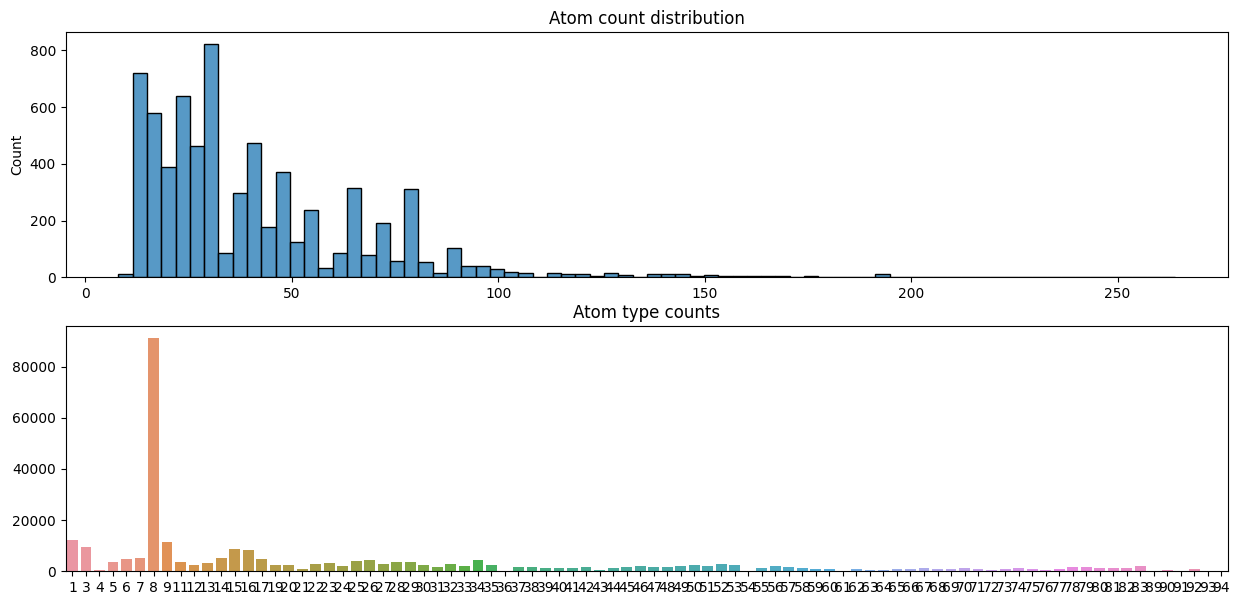

In [8]:
show_atom_distributions(graphs)

In [9]:
model = model_MP.to(device)

def get_predictions(model,dataset):
    model = model.to(device)
    preds = {'node':[],
             'graph':[],
             'edge':[],
             }
    targets = {'node':[],
             'graph':[],
             'edge':[],
             }

    transform = GaussianExpansion(initial=0,final=6,num_centers=100,width=0.5)

    loader =  dgl.dataloading.GraphDataLoader(dataset,batch_size=30)

    with torch.no_grad():
        for g,y in tqdm(loader): 
            g= g.to(device)
            efeats = g.edata['bond_dist_exp'].to(device)
            node_types = g.ndata['node_type'].to(device)
            nfeats,mask = mask_labels(node_types)

            output,attns = compute_attentions(model.net,g,nfeats,efeats)
            preds['node'].append(output['node'].argmax(dim=1)[mask].cpu().numpy())
            preds['graph'].append(output['graph'].squeeze().cpu().numpy())

            targets['node'].append(node_types[mask].cpu().numpy())
            targets['graph'].append(y.cpu().numpy())

    
    preds = {k:np.concatenate(v,axis = 0) for k,v in preds.items()}
    labels = {k:np.concatenate(v,axis = 0) for k,v in labels.items()}
    
    return preds,labels

def node_prediction_report(preds,labels):
    def accuracy_report(labels,preds):
        print("accuracy:",accuracy_score(labels,preds))

        labels_unique = np.unique(labels)
        f1 = f1_score(labels,preds,average=None)
        print("f1_score:")
        for i, label in enumerate(labels_unique):
            print(f'\t{mg.Element.from_Z(label).name}: {f1[i]}')
        print("\tavg(macro):", f1_score(labels,preds,average='macro'))
        print("\tavg(weighted):", f1_score(labels,preds,average='weighted'))
        print()
        print('Labels counts:', ',  '.join([f'{mg.Element.from_Z(a).name}:{b}' for a,b in np.stack(np.unique(labels,return_counts=True)).T]))
        print('Prediction counts:',',  '.join([f'{mg.Element.from_Z(a).name}:{b}' for a,b in np.stack(np.unique(preds,return_counts=True)).T]))
        return

    def plot_confusion_matrix(labels,preds,label_mappings=None,figsize=None,normalize = None):
        fig = plt.figure(figsize=figsize)
        ax = plt.subplot(111)
        if label_mappings is not None:
            lab = list(label_mappings.keys())
            lab_disp = list(label_mappings.values())
        else:
            lab,lab_disp = None,None
            
        include_values = len(label_mappings) < 30

        cm = confusion_matrix(labels,preds,labels=lab,normalize=normalize)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=lab_disp)
        disp.plot(include_values=include_values,ax=ax)
        plt.show()
    preds,labels = preds['node'],labels['node']
    label_mappings = {l:mg.Element.from_Z(l).name for l in np.unique(np.concatenate((labels['node'],preds)))} 
    accuracy_report(labels,preds)
    plot_confusion_matrix(labels,preds,label_mappings,figsize=(10,10),normalize = None)


def property_prediction_report(preds,labels):
    y_pred = preds['graph']
    y_true = labels['graph']

    def r2_score(y_true,y_pred):
        y_pred = np.array(y_pred)
        y_true = np.array(y_true)
        mean_y = np.mean(y_true)
        SSR = np.sum((y_pred - y_true) ** 2)
        SST = np.sum((y_true - mean_y) ** 2)
        return 1 - SSR / SST

    def parity_plot(y,y_hat,title = None,use_log_scale=False):
        min = np.min([np.min(y), np.min(y_hat)])
        max = np.max([np.max(y), np.max(y_hat)])

        MAEs = np.abs(np.array(y_hat) - np.array(y))
        # plt.rcParams['font.size']=12

        colormap = plt.get_cmap('plasma')
        color = colormap(0)
        fig = plt.figure(figsize=(8, 8))
        
        outer = gridspec.GridSpec(2, 1, height_ratios = [19,1],
                                    left=0.1, right=0.9, bottom=0.1, top=0.9,hspace=0.2
                                ) 
        # outer[0].set_title('CACCA PUPU')
        gs1 = gridspec.GridSpecFromSubplotSpec(3, 2, 
                                            subplot_spec = outer[0],
                                            height_ratios=(.1,1,7),
                                            width_ratios=(7, 1),
                                            wspace=0.01, hspace=0.01)
        gs2 = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec = outer[1], width_ratios=(7, 1),wspace=0.01)
        ax_title = fig.add_subplot(gs1[0,0])
        if title : ax_title.set_title(title)
        ax_title.axis('off')
        
        ax_plot = fig.add_subplot(gs1[2, 0])
        sc = ax_plot.scatter(y_hat,y,marker='.', c=MAEs,cmap=colormap)
        ax_plot.plot([min, max],[min, max],color=color)
        ax_plot.set_xlabel("Predictions")
        ax_plot.set_ylabel("Targets")

        ax_histx = fig.add_subplot(gs1[1, 0], sharex=ax_plot)
        ax_histy = fig.add_subplot(gs1[2, 1], sharey=ax_plot)

        ax_histx.axis('off')
        ax_histy.axis('off')
        if use_log_scale:
            ax_histx.set_yscale('log')
            ax_histy.set_xscale('log')
        ax_histx.hist(y_hat,bins=1000,align='mid', fill=True, color=color,density=True)
        ax_histy.hist(y,bins=1000,orientation='horizontal',align='mid', fill=True, color=color,density=True)
        
        ax_cbar = fig.add_subplot(gs2[0,0])
        cbar = fig.colorbar(sc, cax=ax_cbar, orientation='horizontal')
        cbar.set_label("Absolute Error")
        
        return fig

    title = f"R2 = {r2_score(y_true,y_pred):.3f}"

    print(f'MAE = {(y_true-y_pred).abs().mean():.3f}')
    print(f'ACC = {(1-((y_true-y_pred)/y_true).abs().mean())*100:.2f}%')
    print(f'R2  = {r2_score(y_true,y_pred):.3f}')
    fig = parity_plot(y_true,y_pred,title=title)
    plt.show()

preds,labels = get_predictions(model_MP,dataset)

  0%|          | 0/231 [00:00<?, ?it/s]

accuracy: 0.9642900755368701
f1_score:
	H: 0.9885150110820068
	Li: 0.9465449804432855
	Be: 0.9177489177489178
	B: 0.9748549323017409
	C: 0.9566596194503171
	N: 0.9282907662082515
	O: 0.9953379953379954
	F: 0.9841619005719314
	Na: 0.9475920679886685
	Mg: 0.9071358748778104
	Al: 0.9375481881264456
	Si: 0.9646365422396858
	P: 0.9840994507082972
	S: 0.9748231966053749
	Cl: 0.9691675231243577
	K: 0.9551098376313275
	Ca: 0.9383697813121273
	Sc: 0.9475982532751092
	Ti: 0.9403508771929825
	V: 0.934673366834171
	Cr: 0.9133858267716536
	Mn: 0.9039473684210526
	Fe: 0.9162393162393163
	Co: 0.9141274238227147
	Ni: 0.9460750853242321
	Cu: 0.9195825659914058
	Zn: 0.9147894221351617
	Ga: 0.9367521367521366
	Ge: 0.9316239316239316
	As: 0.9451073985680191
	Se: 0.9755301794453507
	Br: 0.9607072691552062
	Kr: 1.0
	Rb: 0.9548762736535662
	Sr: 0.9605055292259084
	Y: 0.9171483622350675
	Zr: 0.9400386847195358
	Nb: 0.9364791288566243
	Mo: 0.9113233287858117
	Tc: 0.9685534591194969
	Ru: 0.943231441048035
	Rh: 

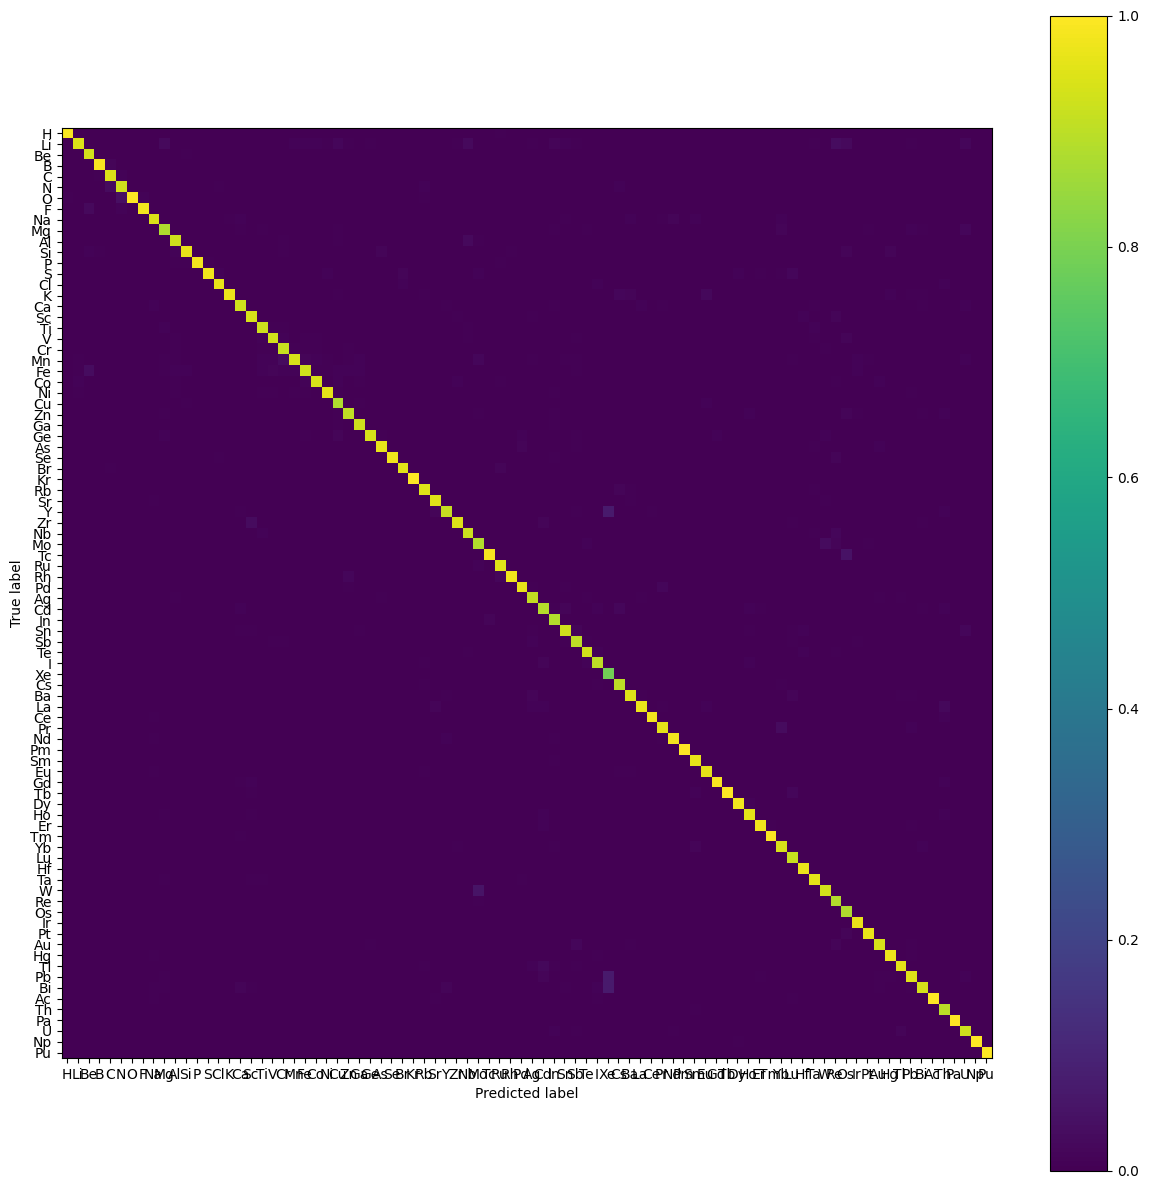

In [11]:
node_prediction_report(preds,labels)

In [ ]:
property_prediction_report(preds,labels)

In [12]:
idx = np.random.randint(len(graphs))
g = graphs[idx]
getView(g).show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

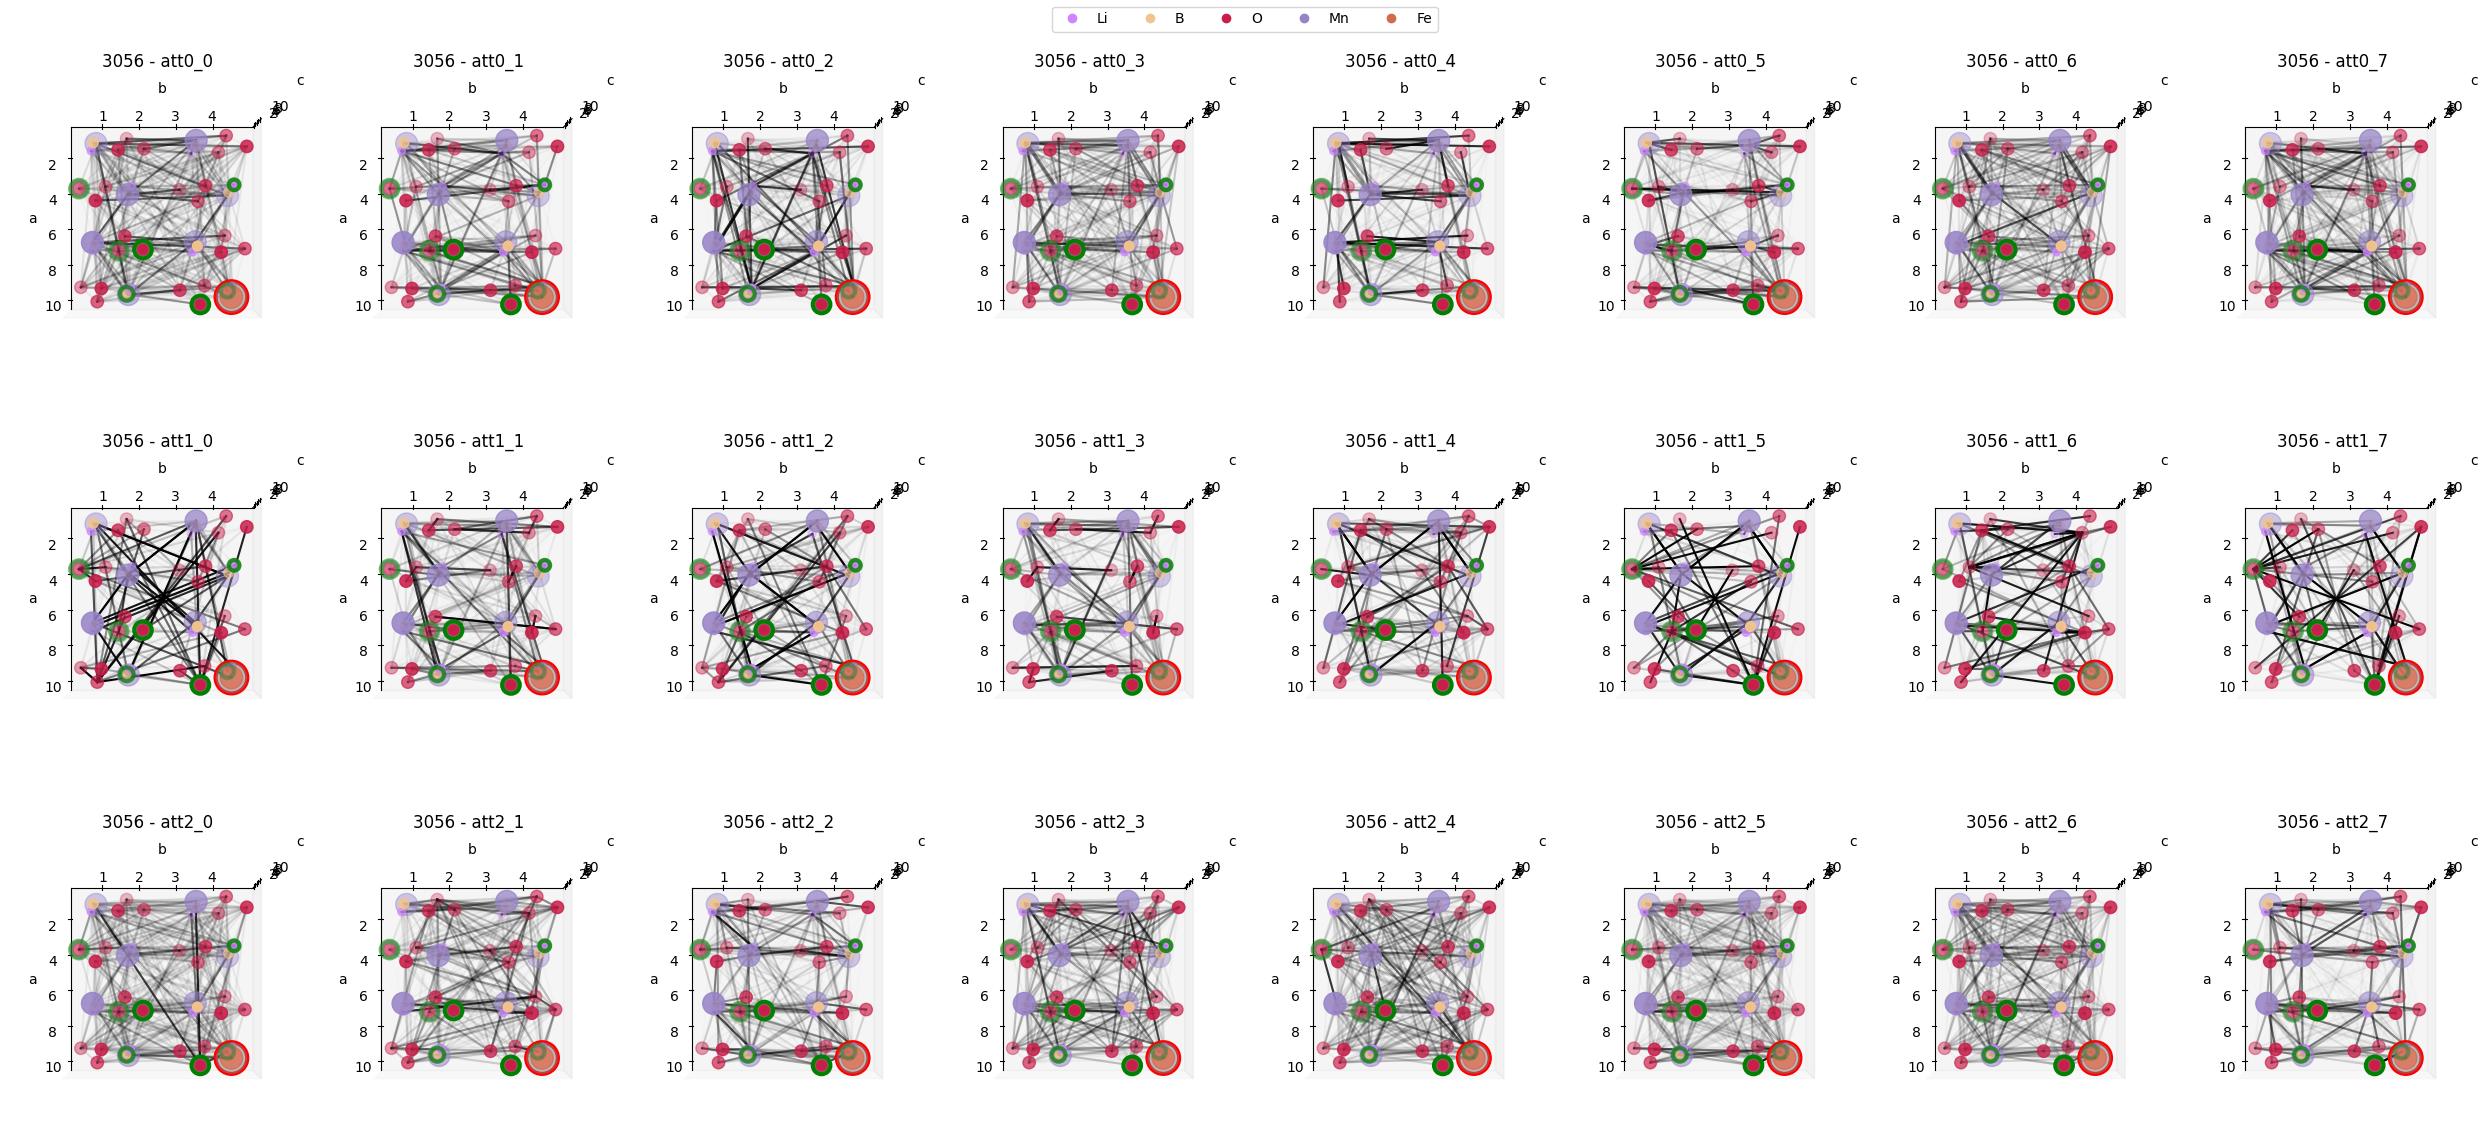

In [13]:
model = model.to('cpu')
g = g.to('cpu')
with torch.no_grad():
    node_types = g.ndata['node_type']
    nfeats,mask = mask_labels(node_types)
    # efeats = transform(g.edata['bond_dist'])
    efeats = g.edata['bond_dist_exp']
    logits,attns = compute_attentions(model.net,g,nfeats,efeats)

if INTERACTIVE:
    display_selector(g,attns,f'{target_dict["graphs_ids"][idx]}',mask,logits.argmax(dim=1))
else: 
    display_attn_grid(g,attns,f'{target_dict["graphs_ids"][idx]}',mask,logits.argmax(dim=1))


In [14]:
del graphs, dataset, target_dict

## QM9

In [15]:
with open('/home/tomcort/data/QM9_splits.json') as f:
    splits = json.load(f)
    
graphs,target_dict = dgl.load_graphs('/home/tomcort/data/QM9_graphs.bin',idx_list=splits['test'])
dataset = MyDataset(graphs)

model_QM9 = PLEGATNodePredictorAndRegressor.load_from_checkpoint('/home/tomcort/MaMoMo/models/QM9-node/model.ckpt')

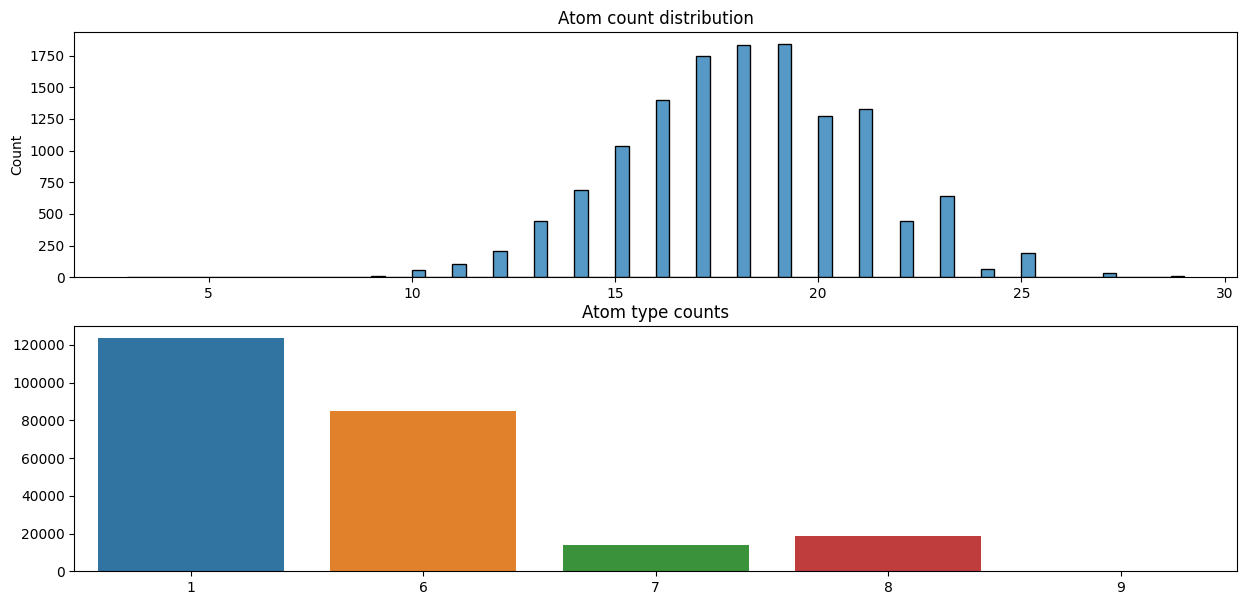

In [16]:
show_atom_distributions(graphs)

In [17]:
preds,labels = get_predictions(model_MP,dataset)

  0%|          | 0/447 [00:00<?, ?it/s]

accuracy: 0.9999177614671354
f1_score:
	H: 1.0
	C: 0.9999415683066495
	N: 0.9994792570734248
	O: 0.9997358689910195
	F: 0.9925925925925926
	avg(macro): 0.9983498573927372
	avg(weighted): 0.9999176906734875

Labels counts: H:24791,  C:17114,  N:2880,  O:3786,  F:68
Prediction counts: H:24791,  C:17114,  N:2881,  O:3786,  F:67


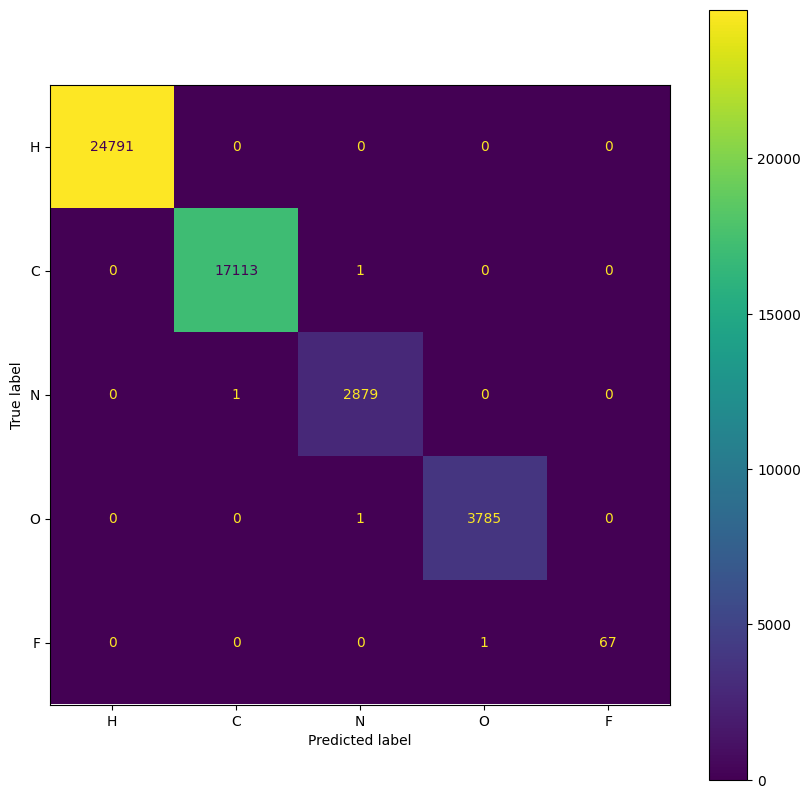

In [18]:
node_prediction_report(preds,labels)

In [ ]:
property_prediction_report(preds,labels)

In [19]:
idx = np.random.randint(len(graphs))
g = graphs[idx].to('cpu') 
getView(g).show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

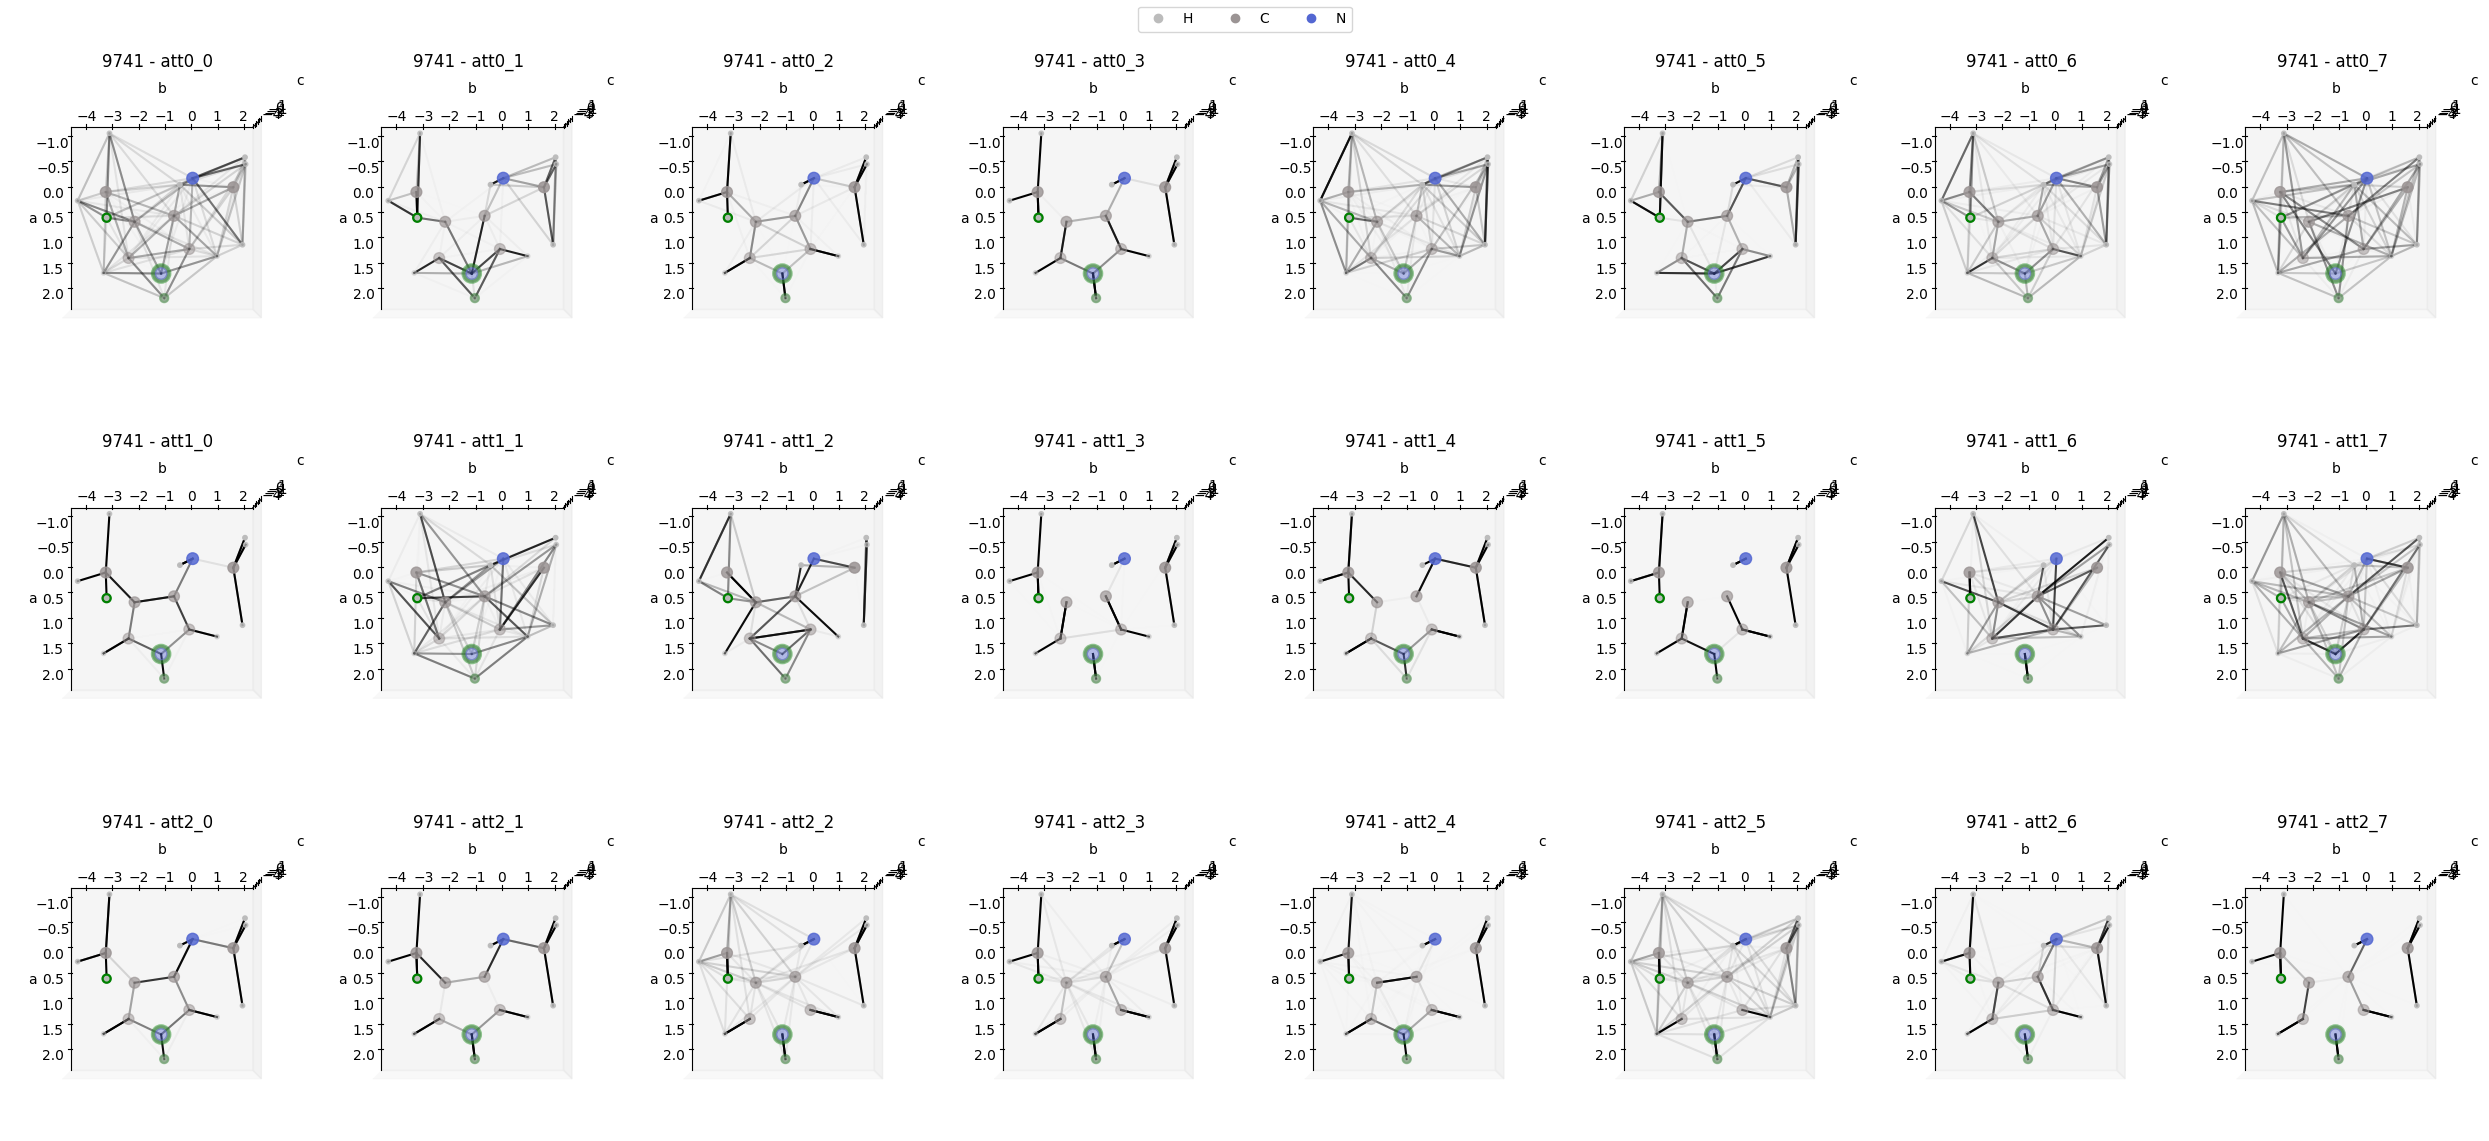

In [20]:
model = model_QM9.to('cpu')
with torch.no_grad():
    node_types = g.ndata['node_type']
    nfeats,mask = mask_labels(node_types)
    efeats = g.edata['bond_dist_exp'] 
    logits,attns = compute_attentions(model.net,g,nfeats,efeats)

preds = logits.argmax(dim=1)

if INTERACTIVE: 
    display_selector(g,attns,f'{target_dict["graphs_ids"][idx]}',mask,logits.argmax(dim=1))
    
else:
    display_attn_grid(g,attns,f'{target_dict["graphs_ids"][idx]}',mask,logits.argmax(dim=1))

In [21]:
del graphs, dataset, target_dict

## GO_ref

In [22]:
with open('/home/tomcort/data/GO_ref_splits.json') as f:
    splits = json.load(f)
graphs,target_dict = dgl.load_graphs('/home/tomcort/data/GO_ref_graphs.bin',idx_list=splits['test'])
dataset = MyDataset(graphs)

model_GO = PLEGATNodePredictorAndRegressor.load_from_checkpoint('/home/tomcort/MaMoMo/models/GO_ref-node/model.ckpt')

In [ ]:
show_atom_distributions(graphs)

In [23]:
preds,labels = get_predictions(model_GO,dataset)

  0%|          | 0/24 [00:00<?, ?it/s]

accuracy: 0.9999591515782809
f1_score:
	H: 0.9999691786099553
	C: 0.999969715324046
	O: 0.9999042176175729
	avg(macro): 0.9999477038505247
	avg(weighted): 0.9999591512411056

Labels counts: H:16223,  C:66039,  O:15661
Prediction counts: H:16222,  C:66041,  O:15660


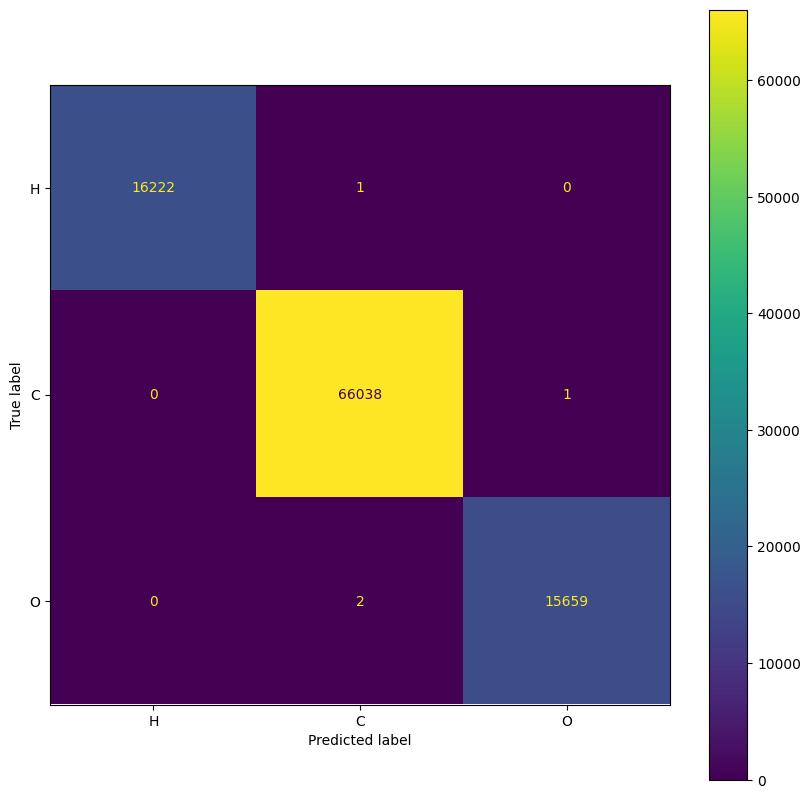

In [24]:
node_prediction_report(preds,labels)

In [ ]:
property_prediction_report(preds,labels)

In [25]:
idx = np.random.randint(len(graphs))
g = graphs[idx].to('cpu') 
getView(g).show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [ ]:
model = model_GO.to('cpu')
with torch.no_grad():
    node_types = g.ndata['node_type']
    nfeats,mask = mask_labels(node_types)
    efeats = g.edata['bond_dist_exp'] 
    logits,attns = compute_attentions(model.net,g,nfeats,efeats)

preds = logits.argmax(dim=1)

if True: #full grid is too heavy to handle
    display_selector(g,attns,f'{target_dict["graphs_ids"][idx]}')
    
else:
    display_attn_grid(g,attns,f'{target_dict["graphs_ids"][idx]}')

In [ ]:
del graphs, dataset, target_dict